In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
os.chdir('/home/ch3859/comp-class/comp-lab-class/Week4/Analysis/')

## Gmx commands used after simulation

Use gmx trjcat to concatenate the trajectories:

`gmx_mpi trjcat -f step5_1.xtc step5_2.xtc step5_3.xtc step5_4.xtc step5_5.xtc step5_6.xtc step5_7.xtc step5_8.xtc step5_9.xtc -o concat_traj.xtc -settime`

Use gmx trjconv to unwarp:

`gmx_mpi trjconv -s step5_9.tpr -f concat_traj.xtc -ur compact -pbc nojump -o unwrap.xtc`

Use gmx trjconv to generate corresponding gro file:

`gmx_mpi trjconv -s step5_9.tpr -f step5_9.gro -ur compact -pbc nojump -o unwrap.gro`

## Trajectory analysis

In [2]:
# read in the trajectory
traj = md.load_xtc('../Setup/NaCl_CHARMM36M/gromacs/unwrap.xtc', top='../Setup/NaCl_CHARMM36M/gromacs/unwrap.gro')
print('total traj time (ns): ', traj.time.max()/1000)

total traj time (ns):  9.0


#### Defination of Mean Squared Displacement
reference: https://docs.mdanalysis.org/2.0.0/documentation_pages/analysis/msd.html
$$MSD(r_d) = \langle \frac{1}{N} \sum_{i=1}^{N} |r_d - r_d(t_0)|^2 \rangle_{t_0}$$

- $N$ is the number of particles.
- $r$ is the coordinate.
- $\langle\rangle$ is the average value over all possible lag-times


In [18]:
def compute_msd(traj, atom_type):
    """Compute the mean-squared displacement of a set of particles.
    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to analyze.
    atom_type : int
        The type of selected atoms.
    Returns
    -------
    msd : np.ndarray
        The MSD of the particles.
    """
    # get the indices of the selected atoms
    if atom_type == 'Na':
        atom_indices = traj.topology.select('name==SOD')
    elif atom_type == 'Cl':
        atom_indices = traj.topology.select('name==CLA')
    elif atom_type == 'O':
        # atom_indices = traj.topology.select('symbol == %s' % atom_type)
        atom_indices = traj.topology.select('name==O')
    else:
        raise ValueError('atom_type must be Na, Cl, or O')
    # compute the displacement squared
    disp = traj.xyz[:, atom_indices, :] - traj.xyz[0, atom_indices, :]
    disp = disp**2
    # compute the msd
    msd = np.zeros(traj.n_frames)
    for i in range(traj.n_frames):
        msd[i] = np.mean(np.sum(disp[:i+1], axis=2) / len(atom_indices))
    
    return msd

In [47]:
# read msd_oxygen.xvg
msd_O = np.loadtxt('../Setup/NaCl_CHARMM36M/gromacs/msd_oxygen.xvg', skiprows=20)[:,1]
msd_Cl = np.loadtxt('../Setup/NaCl_CHARMM36M/gromacs/msd_cl.xvg', skiprows=20)[:,1]
msd_Na = np.loadtxt('../Setup/NaCl_CHARMM36M/gromacs/msd_na.xvg', skiprows=20)[:,1]

In [19]:
# Compute the MSD of Oxygen, Sodium, and Chlorine
# msd_O = compute_msd(traj, 'O')
msd_Na = compute_msd(traj, 'Na')
msd_Cl = compute_msd(traj, 'Cl')

In [44]:
len(msd_Na)

901

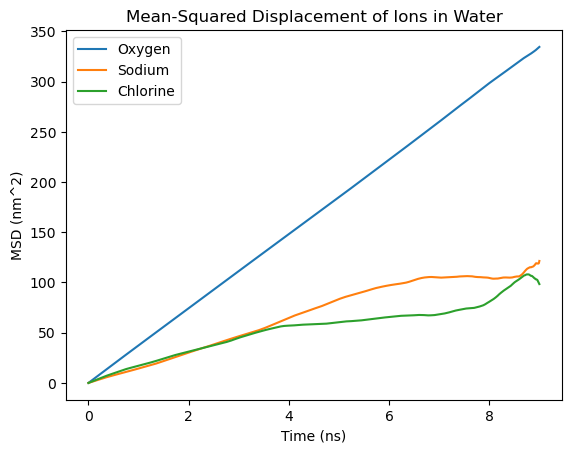

In [49]:
# Plot the MSD vs time of all 3 on the same plot
plt.plot(traj.time/1000, msd_O, label='Oxygen')
plt.plot(traj.time/1000, msd_Na, label='Sodium')
plt.plot(traj.time/1000, msd_Cl, label='Chlorine')
plt.xlabel('Time (ns)')
plt.ylabel('MSD (nm^2)')
plt.legend()
plt.title('Mean-Squared Displacement of Ions in Water')
plt.savefig('../Figures/ions_in_water_msd.pdf', dpi=300)
plt.show()

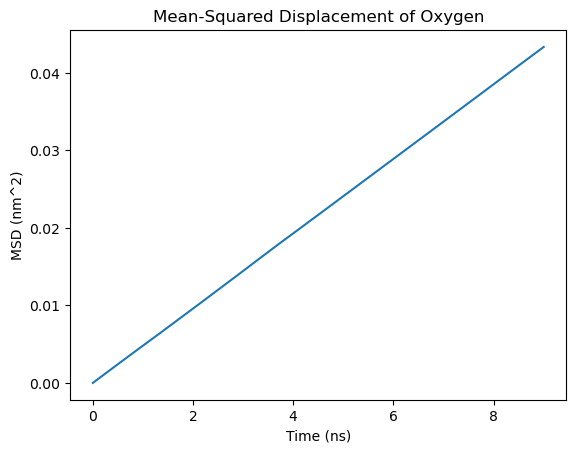

In [23]:
plt.plot(traj.time/1000, msd_O)
plt.xlabel('Time (ns)')
plt.ylabel('MSD (nm^2)')
plt.title('Mean-Squared Displacement of Oxygen')
plt.savefig('../Figures/water_oxygen_msd.pdf', dpi=300)
plt.show()


The average displacement of Oxygen over all the water molecules in the simulation box is quite small (but not zero). It is because only limited water molecules can interact with Na and Cl atoms. As a result, the MSD of Oxygen atoms increases linearly with time, which is typical for a random walk process.